# Explainability LIME-Driven Application Experiments 2: Development of User-Required Features, such as Global Bar Charts Showing Real vs Fake Feature Counts, and Highlighted Text Algorithm

## Environment Setup

In [1]:
# Imports the required libraries
import pandas as pd
import numpy as np
# Monitors the pandas progress
from tqdm import tqdm 
# For counting the text features
import string 
# For displaying the highlighted text with LIME-color coded explanations
from IPython.display import display, HTML 
# For extracting best hyperparameter string representation from saved .csv file to the original datatype
from collections import OrderedDict 

# Imports the required nltk libraries for text processing and feature extraction
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk import pos_tag
# Downloads the nltk packages for stopwords, tagging etc.
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')
# Creates a set out of English stopwords to use in word clouds etc.
stop_words = set(stopwords.words('english'))
# For POS-tag feature extraction with Penn Treebank tagset
import spacy
# Imports the NRC emotion lexicon for 8 categories of emotions for feature scores
from nrclex import NRCLex
# Imports textstat for extracting readability features
import textstat

# Imports visualization libraires
import matplotlib.pyplot as plt 
import seaborn as sns
from wordcloud import WordCloud

# Imports feature pre-processing for model training tools
from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF Vectorizer
from sklearn.compose import ColumnTransformer # ColumnTransformer for adding extra features to TF-IDF vectors
from sklearn.preprocessing import StandardScaler # Scales all features down to same feature space
# Imports model training and evaluation packages
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Imports the LIME explainer for interpreting most important features for a prediction
from lime.lime_text import LimeTextExplainer

[nltk_data] Downloading package wordnet to /Users/ophelia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ophelia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/ophelia/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ophelia/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/ophelia/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ophelia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Sets up the file paths to the All-Four combined datasets
train_data_path = "../FPData/BasicFeatureExtractionDFs/all_four_datasets_train_basic_features.csv"
val_data_path = "../FPData/BasicFeatureExtractionDFs/all_four_datasets_val_basic_features.csv"
test_data_path = "../FPData/BasicFeatureExtractionDFs/all_four_datasets_test_basic_features.csv"

# Imports the combined all-4-dataset DataFrames from .csv files
train_data_df = pd.read_csv(train_data_path)
val_data_df = pd.read_csv(val_data_path)
test_data_df = pd.read_csv(test_data_path)

# Stores the column names of the extra features
extra_feature_columns = [
    "exclamation_point_frequency", "third_person_pronoun_frequency", "noun_to_verb_ratio",
    "cardinal_named_entity_frequency", "person_named_entity_frequency", 
    "nrc_positive_emotion_score", "nrc_trust_emotion_score", 
    "flesch_kincaid_readability_score", "difficult_words_readability_score", 
    "capital_letter_frequency"
]

# Imports the optimized TF-IDF and Passiev Aggressive Classifier hyperparameters for this dataset
opt_hyperparams_path = "../FPData/BasicFeaturesHyperparameterOptimizationResults/optimized_hyperparameters_All_Four_Combined.csv"
hyperparams_df = pd.read_csv(opt_hyperparams_path)

# Extracts the hyperparameter config as string from DF column
best_hyperparams_as_string = hyperparams_df["Best Hyperparameters"].iloc[0]
print(type(best_hyperparams_as_string)) # Prints the data type to confirm this is a string

# Converts the string to the original data type (OrderedDict) using the eval method
best_hyperparams_as_ordered_dict = eval(best_hyperparams_as_string, {"OrderedDict": OrderedDict})
print(type(best_hyperparams_as_ordered_dict)) # Checks the type is OrderedDict

# Converts the OrderedDict to a normal Python dict
best_hyperparams_as_dict = dict(best_hyperparams_as_ordered_dict)
print(type(best_hyperparams_as_dict)) # Checks the data type is dict now

# Prints the optimized hyperparameter dict
print(f"\nBest params dict for pipeline:\n{best_hyperparams_as_dict}")

<class 'str'>
<class 'collections.OrderedDict'>
<class 'dict'>

Best params dict for pipeline:
{'col_transformer__tfidf__max_df': 0.7, 'col_transformer__tfidf__max_features': 50000, 'col_transformer__tfidf__min_df': 1, 'pac_model__C': 2.6673182125473516, 'pac_model__loss': 'squared_hinge'}


## Plotting Global Real vs Fake News Patterns for Streamlit App

In [3]:
def extractWords(texts, news_category):
    """
    Extract words from a list of news texts for plotting a WordCloud.

    Input Parameters:
        texts (list of strings): list of texts to extract words from
        news_category (str): title for news category being processed (for progress bar)

    Output:
        FreqDist: a NLTK FreqDist storing counts of words for the real or fake
                  news text data rows
    """
    word_list = []  # Stores the words

    # Iterates over the news texts with progress bar
    for text in tqdm(texts, desc=f"Extracting Words for {news_category}", unit="text"):
        
        # Tokenizes the texts
        words = word_tokenize(text)
        
        # Adds only words over length of 5 characters that are not stop words to word clouds
        filtered_words = [word.lower() for word in words if len(word) >= 5 and word.lower() not in stop_words]
        
        # Adds the filtered words to whole list of words
        word_list.extend(filtered_words)
        
    # Converts the word list to frequency distribution and return
    return FreqDist(word_list)


def createRealVsFakeWordClouds(df):
    """
    Generates word clouds of words in real and fake news texts from the dataset,
    and plots them side-by-side.

    Input Parameters:
        df (pd.DataFrame): A dataframe for a training dataset with columns "text" and "label" where "label" is
                            0 for real news and 1 for fake news.
    """

    # Separates the dataset into real and fake news based on the label
    real_news_texts = df[df["label"] == 0]["text"]
    fake_news_texts = df[df["label"] == 1]["text"]
    
    # Extracts the words for real and fake news using the helper function defined above
    real_news_words = extractWords(real_news_texts, "Real News")
    fake_news_words = extractWords(fake_news_texts, "Fake News")
    
    # Finds the words that appear ONLY in real news (not in fake news)
    real_news_exclusive = {word: count for word, count in real_news_words.items() 
                          if word not in fake_news_words}
    
    # Finds the words that appear ONLY in fake news (not in real news)
    fake_news_exclusive = {word: count for word, count in fake_news_words.items() 
                          if word not in real_news_words}
    
    # Creates a word cloud for real news exclusive words
    real_exclusive_wordcloud = WordCloud(
        background_color="white",
        colormap="viridis",
        width=1000,
        height=500).generate_from_frequencies(real_news_exclusive)
    
    # Creates a word cloud for fake news exclusive words
    fake_exclusive_wordcloud = WordCloud(
        background_color="black",
        colormap="inferno",
        width=1000,
        height=500).generate_from_frequencies(fake_news_exclusive)
    
    # Plots the word clouds side-by-side
    plt.figure(figsize=(22, 14))
    
    # Plots real news exclusive words word cloud
    plt.subplot(1, 2, 1)
    plt.imshow(real_exclusive_wordcloud, interpolation="bilinear")
    plt.axis("off") # turn of any axis tick-marks
    plt.title("Words ONLY in Real News (Not in Fake News)")
    
    # Plots fake news exclusive words word cloud
    plt.subplot(1, 2, 2)
    plt.imshow(fake_exclusive_wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Words ONLY in Fake News (Not in Real News)")

    # Improves readability
    plt.tight_layout()
    plt.show()
    
    # Saves the word clouds to disk
    real_exclusive_wordcloud.to_file("../FPData/WordClouds/combined_four_set_training_data_real_news_exclusive_words_wordcloud.png")
    fake_exclusive_wordcloud.to_file("../FPData/WordClouds/combined_four_set_training_data_fake_news_exclusive_words_wordcloud.png")
    
    print("Exclusive word clouds saved successfully to '../FPData/WordClouds/'!")

In [4]:
def extractNamedEntities(texts, nlp, news_category):
    """
        Extracts named entities from a list of news texts to plot a Word cloud

        Input Parameters:
            nlp (spacy model): the loaded large English SpaCy model for extracting named entities
            texts (list of strings): a list of texts to extract named entities from
            news_category (str): the title for news category being processed (for progress bar)

        Output:
            FreqDist: a NLTK FreqDist storing counts of named entities for the real or fake
                      news text data rows
    """

    # Stores the named entities
    entity_list = [] 

    # Tracks the progress with tqdm
    for text in tqdm(texts, desc=f"Extracting Named Entities for {news_category}", unit="text"):
        
        doc = nlp(text) # Creates a document object with spacy for the text
        
        for ent in doc.ents: # Extracts the named entities from text

            # Stores the entities as lowercase, so differently-cased entities have same representation
            entity_list.append(ent.text.lower()) 
    # Returns a frequency distribution of entities based on counting the entities in the list  
    return FreqDist(entity_list)  


def createRealVsFakeNamedEntityWordClouds(df):
    """
    Generates Word clouds of named entities in real and fake news texts from the dataset,
    and display them side-by-side.

    Input Parameters:
        df (pd.DataFrame): A dataframe for a training dataset with columns "text" and "label" where "label" is
                            0 for real news and 1 for fake news.
    """

    # Loads the spaCy model
    nlp = spacy.load("en_core_web_lg")
    
    # Separates the dataset into real and fake news based on the label
    real_news_texts = df[df["label"] == 0]["text"]
    fake_news_texts = df[df["label"] == 1]["text"]
    
    # Extracts the named entities for real and fake news
    real_news_entities = extractNamedEntities(real_news_texts, nlp, "Real News")
    fake_news_entities = extractNamedEntities(fake_news_texts, nlp, "Fake News")

    # Finds the entities that appear in real news but not in fake news
    real_news_only_entities = {entity: count for entity, count in real_news_entities.items() if entity not in fake_news_entities}
    
    # Finds the entities that appear in fake news but not in real news
    fake_news_only_entities = {entity: count for entity, count in fake_news_entities.items() if entity not in real_news_entities}

    # Creates a WordCloud for real news entities (that don't appear in fake news)
    real_news_wordcloud = WordCloud(
        background_color="white",
        colormap="viridis",
        width=1000,
        height=500).generate_from_frequencies(real_news_only_entities)

    # Creates the WordCloud for fake news entities (that don't appear in real news)
    fake_news_wordcloud = WordCloud(
        background_color="black",
        colormap="inferno",
        width=1000,
        height=500).generate_from_frequencies(fake_news_only_entities)

    # Plots the word clouds side-by-side
    plt.figure(figsize=(22, 14))

    # Plots the real news Wordcloud on the first column subplot
    plt.subplot(1, 2, 1)
    plt.imshow(real_news_wordcloud, interpolation="bilinear")
    plt.axis("off") # turns of x-ticks, y-ticks etc. Not needed for wcloud
    plt.title("Real News Entities (absent from Fake News)")

    # Plots fake news wordcloud on the second column subplot
    plt.subplot(1, 2, 2)
    plt.imshow(fake_news_wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Fake News Entities (absent from Real News)")

    # Shows the word clouds
    plt.tight_layout()
    plt.show()

    # Saves the word clouds to disk
    real_news_wordcloud.to_file(f"../FPData/WordClouds/combined_four_set_training_data_real_news_named_entities_wordcloud.png")
    fake_news_wordcloud.to_file(f"../FPData/WordClouds/combined_four_set_training_data_fake_news_named_entities_wordcloud.png")

    print("Word clouds saved successfully to '../FPData/WordClouds/'!")



xtracting Words for Fake News: 100%|██| 25172/25172 [00:28<00:00, 875.94text/s]

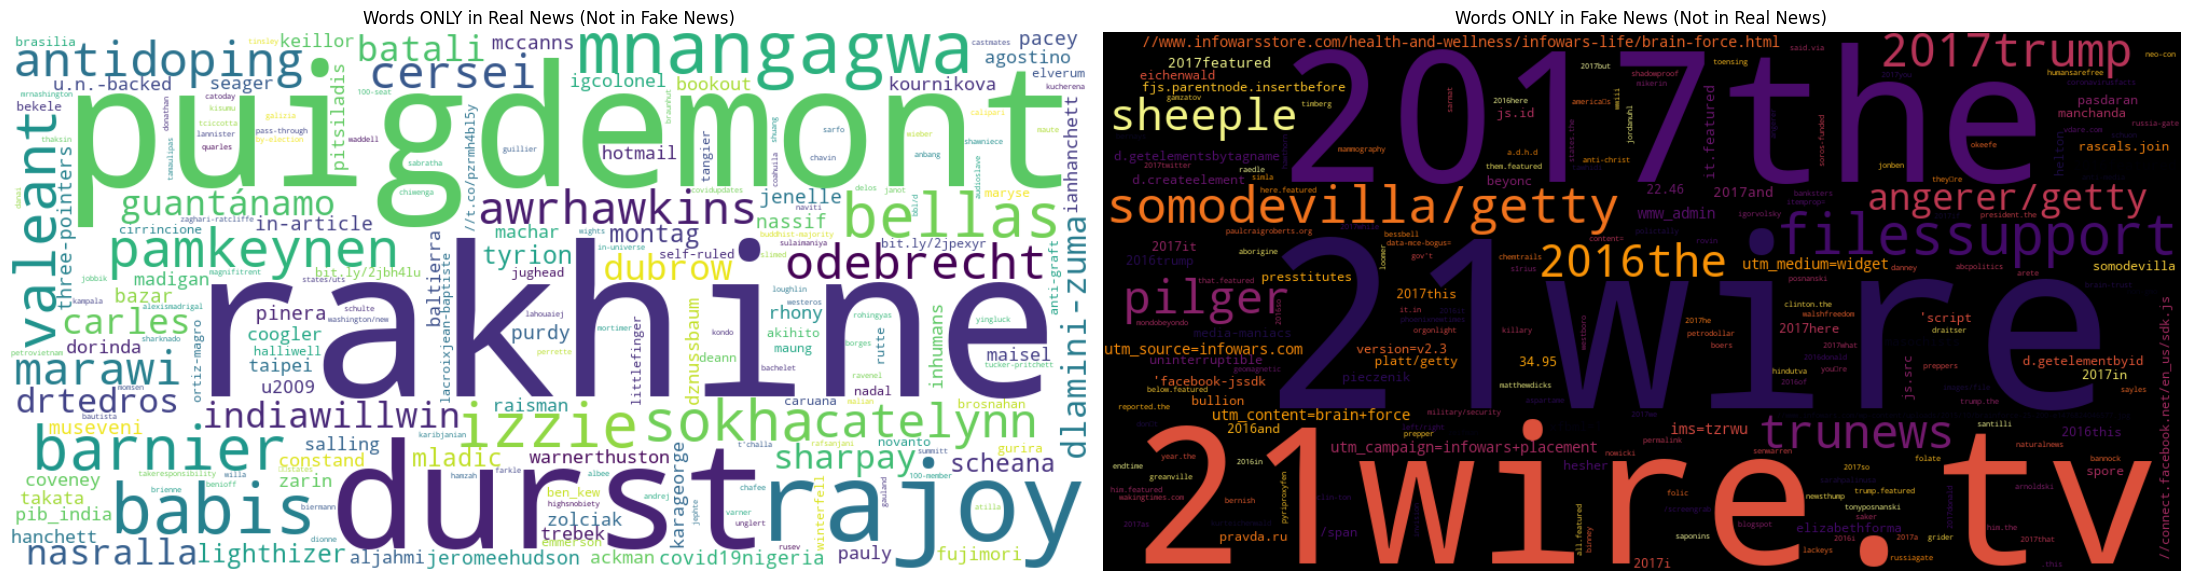

Exclusive word clouds saved successfully to '../FPData/WordClouds/'!


In [4]:
# Creates Word clouds for ordinary words (not named entities) for real vs fake news
createRealVsFakeWordClouds(train_data_df)



xtracting Named Entities for Fake News: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25172/25172 [12:03<00:00, 34.80text/s]

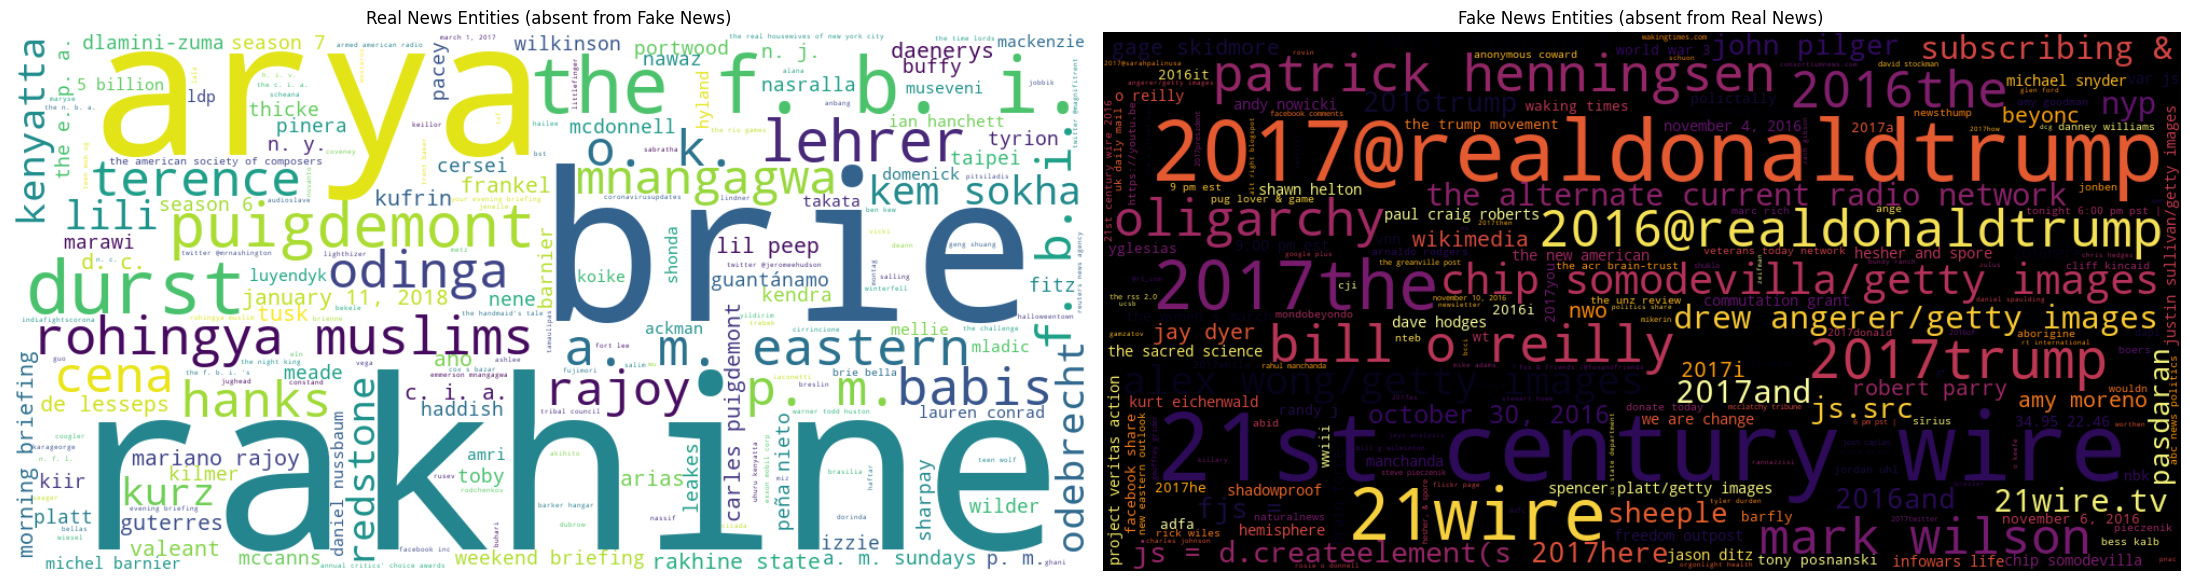

Word clouds saved successfully to '../FPData/WordClouds/'!


In [216]:
# Creates and saves Word clouds for real news vs fake news for NAMED ENTITIES found in the combined four-dataset training data
createRealVsFakeNamedEntityWordClouds(train_data_df)

In [11]:
def countCapitalLetters(text):
    """
    Counts the number of capital letters in the inputted text.

        Input Parameters:
            text (str): the text to count caps letters in
    
        Output:
            int: count of capital alphabetic letters in the text
    """
    return sum(1 for char in text if char.isupper() and char in string.ascii_letters)

def plotCapitalLetterCounts(df):
    """
    Takes in a DataFrame with text and label columns, counts the number of capital letters in each text, 
    and plots a comparison bar chart for real vs fake news.
    
        Input Parameters:
            df (pd.DataFrame): The DataFrame containing the text data and labels.
    """
    # Adds a new column to the DataFrame for the frequency of capital letters
    df["capital_count"] = df["text"].apply(countCapitalLetters)
    
    # Groups by the label (real=0, fake=1 news) and calculate the mean number of capital letters
    capital_count_by_label = df.groupby("label")["capital_count"].mean().reset_index()
    
    # Creates a new column for label mapping (0 = Real News, 1 = Fake News)
    capital_count_by_label["label"] = capital_count_by_label["label"].map({0: "Real News", 1: "Fake News"})
    
    # Defines the custom colors for the bars (blue for real, red for fake)
    color_map = {"Real News": "blue", "Fake News": "red"}
    
    # Creates a matplotlib figure for plotting
    plt.figure(figsize=(8, 6))
    
    # Uses the custom blue/red color map for the bar plot
    sns.barplot(x="capital_count", y="label", data=capital_count_by_label, 
                palette=color_map)
    
    plt.title("Comparison of Capital Letter Counts for Real vs Fake News")
    plt.xlabel("Mean Capital Letters Count")
    plt.ylabel("News Category")

    # Saves plot to disk
    plt.savefig("../FPData/Diagrams/all_four_datasets_capitals_bar_chart_real_vs_fake.png", 
                dpi=300, # Resolution
                bbox_inches="tight", # Adjust plot bounds
                facecolor="white" # Background color
               )
    # Shows the plot in the Jupyter Notebook
    plt.show()

    # Clears it to save memory
    plt.close()

def countExclamationPoints(text):
    """
    Counts the number of exclamation points in the inputted text.

        Input Parameters:
            text (str): the text to count exclamation points in
    
        Output:
            float: normalized count of exclamation points in the text
    """
    # Counts number of exclamation points
    exclamation_count = text.count("!")
    
    # Gets the word token count for normalization
    word_tokens = word_tokenize(text)
    text_length = len(word_tokens)
    
    # Returns the normalized frequency
    return exclamation_count / text_length if text_length > 0 else 0

def plotExclamationFreqs(df):
    """
    Takes in a DataFrame with text and label columns, counts the normalized frequency of 
    exclamation points in each text, and plots a comparison bar chart for real vs fake news.
    
        Input Parameters:
            df (pd.DataFrame): The DataFrame containing the text data and labels.
    """
    # Adds aprogress bar for monitoring processing
    tqdm.pandas(desc="Processing texts to extract exclamation point frequencies...")
    
    # Adds a new column to the DataFrame for exclamation point frequencies
    df["exclamation_freq"] = df["text"].progress_apply(countExclamationPoints)
    
    # Groups by the label (real=0, fake=1 news) and calculate the mean frequency
    exclamation_freq_by_label = df.groupby("label")["exclamation_freq"].mean().reset_index()
    
    # Maps the integer labels to their text categories
    exclamation_freq_by_label["label"] = exclamation_freq_by_label["label"].map(
        {0: "Real News", 1: "Fake News"}
    )
    
    # Defines a custom color map
    color_map = {"Real News": "blue", "Fake News": "red"}
    
    # Creates a bar plot using seaborn library
    plt.figure(figsize=(8, 6))
    sns.barplot(
        x="exclamation_freq", 
        y="label", 
        data=exclamation_freq_by_label, 
        palette=color_map
    )

    # Adds the titles and labels
    plt.title("Comparison of Exclamation Point Frequency for Real vs Fake News")
    plt.xlabel("Mean Exclamation Point Frequency")
    plt.ylabel("News Category")

    # Saves the plot to disk
    plt.savefig("../FPData/Diagrams/all_four_datasets_exclamation_points_bar_chart_real_vs_fake.png", 
                dpi=300,  # Resolution
                bbox_inches="tight",  # Adjust plot bounds
                facecolor="white"  # Background color
               )
    
    plt.show()
    
    # Clears memory
    plt.close()

def extractThirdPersonPronounFreqs(text):
    """
    Extracts the normalized frequency counts of third-person pronouns in the inputted news text.
        
        Input Parameters:
            text (str): the news text to extract pronoun features from.
        
        Output:
            float: Normalized third-person pronoun frequency.
    """
    
    # Sets up the list of third-person pronouns
    third_person_pronouns = [
        "he", "she", "it", "they", "he's", "she's", "it's", "they're", 
        "they've", "they'd", "they'll", "his", "her", "its", "their", 
        "hers", "theirs", "him", "them", "one", "one's", "he'd", "she'd"
    ]

    # Tokenizes the text into word tokens
    word_tokens = word_tokenize(text)
    text_length = len(word_tokens) # Get text-length in word tokens for frequency normalization

    # Counts the frequency of third-person pronouns in the news text, use lower to match the list above
    third_person_count = sum(1 for token in word_tokens if token.lower() in third_person_pronouns)

    # Normalizes the frequency by text length in word tokens
    return third_person_count / text_length if text_length > 0 else 0


def plotThirdPersonPronounFreqs(df):
    """
    Takes in a DataFrame with text and label columns, calculates the normalized frequency of third-person pronouns
    in each text, and plots a comparison bar chart for real vs fake news.
    
        Input Parameters:
            df (pd.DataFrame): The dataframe containing the text data and labels.
    """
    # Adds the  progress bar for monitoring processing of the texts
    tqdm.pandas(desc="Processing texts to extract normalized third-person frequencies...")
    
    # Adds a new column to the DataFrame for third-person pronoun frequencies
    df["third_person_pronoun_freq"] = df["text"].progress_apply(extractThirdPersonPronounFreqs)
    
    # Groups by the label (real=0, fake=1 news) and calculate the mean pronoun frequency
    pronoun_freq_by_label = df.groupby("label")["third_person_pronoun_freq"].mean().reset_index()
    
    # Maps the labels to their respective categories
    pronoun_freq_by_label["label"] = pronoun_freq_by_label["label"].map({0: "Real News", 1: "Fake News"})
    
    # Defines a custom color map
    color_map = {"Real News": "blue", "Fake News": "red"}
    
    # Creates a bar plot
    plt.figure(figsize=(8, 6))
    sns.barplot(
        x="third_person_pronoun_freq", 
        y="label", 
        data=pronoun_freq_by_label, 
        palette=color_map
    )
    
    plt.title("Comparison of Third-Person Pronoun Frequency for Real vs Fake News")
    plt.xlabel("Mean Third-Person Pronoun Frequency")
    plt.ylabel("News Category")

    # Saves the plot to disk
    plt.savefig("../FPData/Diagrams/all_four_datasets_third_person_pronouns_bar_chart_real_vs_fake.png", 
                dpi=300, # Resolution
                bbox_inches="tight", # Adjust plot bounds
                facecolor="white" # Background color
               )

    
    plt.show()

    # Clears memory
    plt.close()



def extractEmotionFreqs(text):
    """
    Extracts the normalized frequency counts of emotions using NRCLex.
    
        Input Parameters:
            text (str): The news text to analyze
        
        Output:
            dict: Normalized frequencies for each emotion category
    """
    
    # Creates a NRCLex object from the text
    emotion_analyzer = NRCLex(text)
    
    # Gets the raw emotion counts
    raw_counts = emotion_analyzer.raw_emotion_scores
    
    # Defines all the possible emotions to ensure they exist in output
    all_emotions = ["anger", "anticipation", "disgust", "fear", "joy", 
                   "sadness", "surprise", "trust", "positive", "negative"]
    
    # Gets the word token count for normalization
    word_tokens = word_tokenize(text)
    text_length = len(word_tokens)
    
    # Creates a normalized dictionary with all emotions, defaulting to 0 if not present
    normalized_counts = {}
    for emotion in all_emotions:
        count = raw_counts.get(emotion, 0)  # Use get() with default 0 if emotion not present
        normalized_counts[emotion] = count/text_length if text_length > 0 else 0
    
    return normalized_counts
    

def plotEmotionFreqs(df):
    """
    Takes in a DataFrame with text and label columns, calculates the normalized frequency 
    of emotions using NRCLex, and plots a comparison bar chart for real vs fake news.
    
        Input Parameters:
            df (pd.DataFrame): The dataframe containing the text data and labels
    """
    # Adds a progress bar for monitoring processing
    tqdm.pandas(desc="Processing texts for emotion analysis...")
    
    # Extracts the emotion frequencies for each text
    df["emotion_freqs"] = df["text"].progress_apply(extractEmotionFreqs)
    
    # Converts the dictionary column to separate columns for each emotion
    emotion_cols = ["anger", "anticipation", "disgust", "fear", "joy", 
                   "sadness", "surprise", "trust", "positive", "negative"]

    # Creates the emotion columns in the DataFrames
    for emotion in emotion_cols:
        df[emotion] = df["emotion_freqs"].apply(lambda x: x[emotion])
    
    # Calculate smean frequencies for real and fake news
    emotion_freqs_by_label = df.groupby("label")[emotion_cols].mean().reset_index()
    
    # Maps the news category labels to text strings
    emotion_freqs_by_label["label"] = emotion_freqs_by_label["label"].map(
        {0: "Real News", 1: "Fake News"}
    )
    
    # Reshapes data for plotting, convert from wide (column for each emotion) to long format (emotions as cell values)
    emotion_freqs_melted = pd.melt(
        emotion_freqs_by_label,
        id_vars=["label"],
        value_vars=emotion_cols,
        var_name="emotion",
        value_name="frequency"
    )
    
    # Creates the plot
    plt.figure(figsize=(15, 8))
    sns.barplot(
        x="emotion",
        y="frequency",
        hue="label",
        data=emotion_freqs_melted,
        palette={"Real News": "blue", "Fake News": "red"}
    )

    # Sets the titles and labels
    plt.title("Comparison of Emotion Word Frequencies in Real vs Fake News")
    plt.xlabel("Emotion Category")
    plt.ylabel("Mean Normalized Frequency")
    plt.xticks(rotation=45)
    plt.legend(title="News Category")
    plt.tight_layout()

    # Saves the plot to disk
    plt.savefig("../FPData/Diagrams/all_four_datasets_emotions_bar_chart_real_vs_fake.png",
                dpi=300,
                bbox_inches="tight",
                facecolor="white"
               )
    
    plt.show()
    
    # Clears the memory
    plt.close()


def extractNamedEntityFreqs(text, entity_type):
    """
    Extracts the normalized frequency counts of specified named entity type in the text.

        Input Parameters:
            text (str): The news text to analyze
            entity_type (str): The type of named entity to count (e.g., "PERSON", "CARDINAL")
    
        Output:
            float: Normalized frequency of the specified named entity type
    """
    # Loads the large English spaCy model
    nlp = spacy.load("en_core_web_lg")
    
    # Processes the text as NLP doc
    doc = nlp(text)
    
    # Counts the entities of the specified types
    entity_count = sum(1 for ent in doc.ents if ent.label_ == entity_type)
    
    # Gets word count for normalizing frequencies
    word_tokens = word_tokenize(text)
    text_length = len(word_tokens)
    
    # Returns the normalized frequency
    return entity_count / text_length if text_length > 0 else 0
    

def plotPersonNamedEntityFreqs(df):
    """
    Takes in a DataFrame with text and label columns, calculates the normalized frequency of 
    PERSON named entities in each text, and plots a comparison bar chart for real vs fake news.
    
        Input Parameters:
            df (pd.DataFrame): The dataframe containing the text data and labels.
    """
    # Adds the progress bar for monitoring processing
    tqdm.pandas(desc="Processing texts to extract PERSON named entity frequencies...")
    
    # Adds a new column to the DataFrame for PERSON frequencies, use helper function to extract this NEntity
    df["person_freq"] = df["text"].progress_apply(lambda x: extractNamedEntityFreqs(x, "PERSON"))
    
    # Groups by the label and calculate mean frequency
    person_freq_by_label = df.groupby("label")["person_freq"].mean().reset_index()
    
    # Maps integer labels to text categories
    person_freq_by_label["label"] = person_freq_by_label["label"].map({0: "Real News", 1: "Fake News"})
    
    # Defines the color map for real vs fake news (blue vs red)
    color_map = {"Real News": "blue", "Fake News": "red"}
    
    # Creates the plot
    plt.figure(figsize=(8, 6))
    sns.barplot(
        x="person_freq", 
        y="label", 
        data=person_freq_by_label, 
        palette=color_map
    )
    
    plt.title("Comparison of Person Named Entity Frequency for Real vs Fake News")
    plt.xlabel("Mean Person Named Entity Frequency")
    plt.ylabel("News Category")

    # Saves the plot to disk
    plt.savefig("../FPData/Diagrams/all_four_datasets_person_named_entities_bar_chart_real_vs_fake.png", 
                dpi=300,
                bbox_inches="tight",
                facecolor="white"
               )
    
    plt.show()
    
    # Clears the memory
    plt.close()
    

def plotCardinalNamedEntityFreqs(df):
    """
    Takes in a DataFrame with text and label columns, calculates the normalized frequency of 
    CARDINAL named entities in each text, and plots a comparison bar chart for real vs fake news.
    
        Input Parameters:
            df (pd.DataFrame): The dataframe containing the text data and labels.
    """
    # Adds the progress bar for monitoring processing
    tqdm.pandas(desc="Processing texts to extract CARDINAL named entity frequencies...")
    
    # Adds a new column to the DataFrame for CARDINAL frequencies
    df["cardinal_freq"] = df["text"].progress_apply(lambda x: extractNamedEntityFreqs(x, "CARDINAL"))
    
    # Groups by the label and calculate mean frequency
    cardinal_freq_by_label = df.groupby("label")["cardinal_freq"].mean().reset_index()
    
    # Maps integer labels to text categories
    cardinal_freq_by_label["label"] = cardinal_freq_by_label["label"].map({0: "Real News", 1: "Fake News"})
    
    # Defines the color map
    color_map = {"Real News": "blue", "Fake News": "red"}
    
    # Creates the plot
    plt.figure(figsize=(8, 6))
    sns.barplot(
        x="cardinal_freq", 
        y="label", 
        data=cardinal_freq_by_label, 
        palette=color_map
    )
    
    plt.title("Comparison of Cardinal Number Frequency for Real vs Fake News")
    plt.xlabel("Mean Cardinal Number Frequency")
    plt.ylabel("News Category")

    # Saves the plot to disk
    plt.savefig("../FPData/Diagrams/all_four_datasets_cardinal_named_entities_bar_chart_real_vs_fake.png", 
                dpi=300,
                bbox_inches="tight",
                facecolor="white"
               )
    
    plt.show()
    
    # Clear memory
    plt.close()
    


def calculateNounToVerbRatio(text):
    """
    Calculate noun-to-verb ratio with spacy.
    
        Input Parameters:
            text (str): The text to extract ratio from
            
        Output:
            float: Ratio of nouns to verbs, or 0.0 if no verbs are in the text
    """
    # Loads the SpaCy model
    nlp = spacy.load("en_core_web_lg")
    
    # Processes the text as nlp spacy doc
    doc = nlp(text)
    
    # Defines the noun/verb pos tags
    noun_tags = ["NN", "NNS", "NNP", "NNPS"]
    verb_tags = ["VB", "VBD", "VBG", "VBN", "VBP", "VBZ"]
    
    # Counts the nouns and verb
    noun_count = sum(1 for token in doc if token.tag_ in noun_tags)
    verb_count = sum(1 for token in doc if token.tag_ in verb_tags)
    
    # Calculates and return the ratio
    return noun_count / verb_count if verb_count > 0 else 0.0
    

def plotNounToVerbRatios(df):
    """
    Takes in a DataFrame with text and label columns, calculates the noun-to-verb ratio
    in each text, and plots a comparison bar chart for real vs fake news.
    
        Input Parameters:
            df (pd.DataFrame): The pandas DataFrame containing the text data and labels.
    """
    # Adds a progress bar for monitoring processing
    tqdm.pandas(desc="Processing texts to extract noun-to-verb ratios...")
    
    # Adds a new column to the DataFrame for noun-to-verb ratios
    df["noun_to_verb_ratio"] = df["text"].progress_apply(calculateNounToVerbRatio)
    
    # Groups by the label and calculate mean ratio
    ratio_by_label = df.groupby("label")["noun_to_verb_ratio"].mean().reset_index()
    
    # Maps integer labels to text categories
    ratio_by_label["label"] = ratio_by_label["label"].map({0: "Real News", 1: "Fake News"})
    
    # Defines the color map for real vs fake news (blue vs red)
    color_map = {"Real News": "blue", "Fake News": "red"}
    
    # Creates the plot
    plt.figure(figsize=(8, 6))
    sns.barplot(
        x="noun_to_verb_ratio", 
        y="label", 
        data=ratio_by_label, 
        palette=color_map
    )
    
    plt.title("Comparison of Noun-to-Verb Ratio for Real vs Fake News")
    plt.xlabel("Mean Noun-to-Verb Ratio")
    plt.ylabel("News Category")

    # Saves the plot to disk
    plt.savefig("../FPData/Diagrams/all_four_datasets_noun_to_verb_ratio_bar_chart_real_vs_fake.png", 
                dpi=300,
                bbox_inches="tight",
                facecolor="white"
               )
    
    plt.show()
    
    # Clears the memory
    plt.close()


def plotFleschKincaidReadability(df):
    """
    Takes in a DataFrame with text and label columns, calculates the Flesch-Kincaid readability
    grade level for each text, and plots a comparison bar chart for real vs fake news.
    
        Input Parameters:
            df (pd.DataFrame): The pandas DataFrame containing the text data and labels.
    """
    # Adds a progress bar for monitoring processing
    tqdm.pandas(desc="Processing texts to extract Flesch-Kincaid readability scores...")
    
    # Adds a new column to the DataFrame for Flesch-Kincaid readability scores
    df["flesch_kincaid_score"] = df["text"].progress_apply(lambda text: textstat.flesch_kincaid_grade(text))
    
    # Groups by the label and calculate mean ratio
    readability_by_label = df.groupby("label")["flesch_kincaid_score"].mean().reset_index()
    
    # Maps the integer labels to text categories
    readability_by_label["label"] = readability_by_label["label"].map({0: "Real News", 1: "Fake News"})
    
    # Defines a color map for real vs fake news (blue vs red)
    color_map = {"Real News": "blue", "Fake News": "red"}
    
    # Creates the plot
    plt.figure(figsize=(8, 6))
    sns.barplot(
        x="flesch_kincaid_score", 
        y="label", 
        data=readability_by_label, 
        palette=color_map
    )
    
    plt.title("Comparison of Flesch-Kincaid Readability Grade Level for Real vs Fake News")
    plt.xlabel("Mean Flesch-Kincaid Grade Level")
    plt.ylabel("News Category")

    # Saves the plot to disk
    plt.savefig("../FPData/Diagrams/all_four_datasets_flesch_kincaid_readability_bar_chart_real_vs_fake.png", 
                dpi=300,
                bbox_inches="tight",
                facecolor="white"
               )
    
    plt.show()
    
    # Clears memory
    plt.close()



def plotDifficultWordsScore(df):
    """
    Takes in a DataFrame with text and label columns, calculates the difficult words
    score for each text, and plots a comparison bar chart for real vs fake news.
    
        Input Parameters:
            df (pd.DataFrame): The pandas DataFrame containing the text data and labels.
    """
    # Adds a progress bar for monitoring processing
    tqdm.pandas(desc="Processing texts to extract difficult words scores...")
    
    # Adds a new column to the DataFrame for difficult words scores
    df["difficult_words_score"] = df["text"].progress_apply(lambda text: textstat.difficult_words(text.lower()))
    
    # Groups by the news label and calculates the mean ratio
    difficult_words_by_label = df.groupby("label")["difficult_words_score"].mean().reset_index()
    
    # Maps the integer labels to text categories
    difficult_words_by_label["label"] = difficult_words_by_label["label"].map({0: "Real News", 1: "Fake News"})
    
    # Defines the color map for real vs fake news (blue vs red)
    color_map = {"Real News": "blue", "Fake News": "red"}
    
    # Creates the plot
    plt.figure(figsize=(8, 6))
    sns.barplot(
        x="difficult_words_score", 
        y="label", 
        data=difficult_words_by_label, 
        palette=color_map
    )
    
    plt.title("Comparison of Difficult Words Score for Real vs Fake News")
    plt.xlabel("Mean Number of Difficult Words")
    plt.ylabel("News Category")

    # Saves the plot to disk
    plt.savefig("../FPData/Diagrams/all_four_datasets_difficult_words_score_bar_chart_real_vs_fake.png", 
                dpi=300,
                bbox_inches="tight",
                facecolor="white"
               )
    
    plt.show()
    
    # Clears the memory
    plt.close()

/var/folders/j1/kcm7s9bd1xj_77kfdwvq2_xc0000gn/T/ipykernel_986/2134805678.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="capital_count", y="label", data=capital_count_by_label,


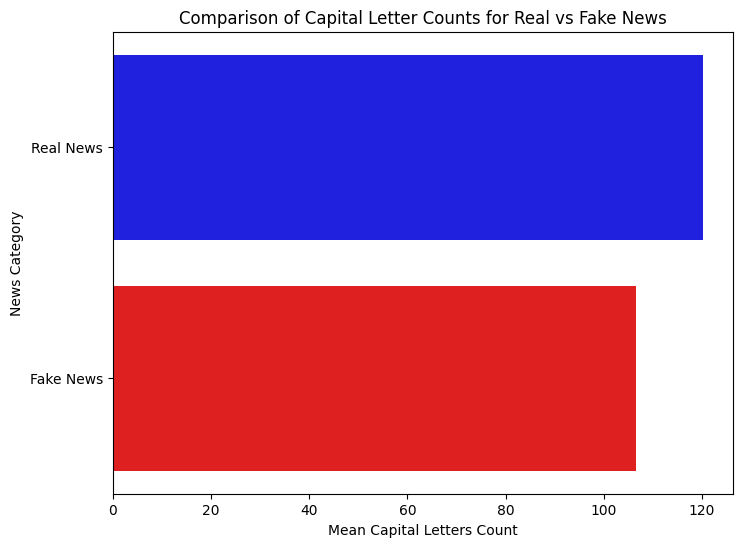

In [265]:
plotCapitalLetterCounts(train_data_df)


/var/folders/j1/kcm7s9bd1xj_77kfdwvq2_xc0000gn/T/ipykernel_986/2134805678.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


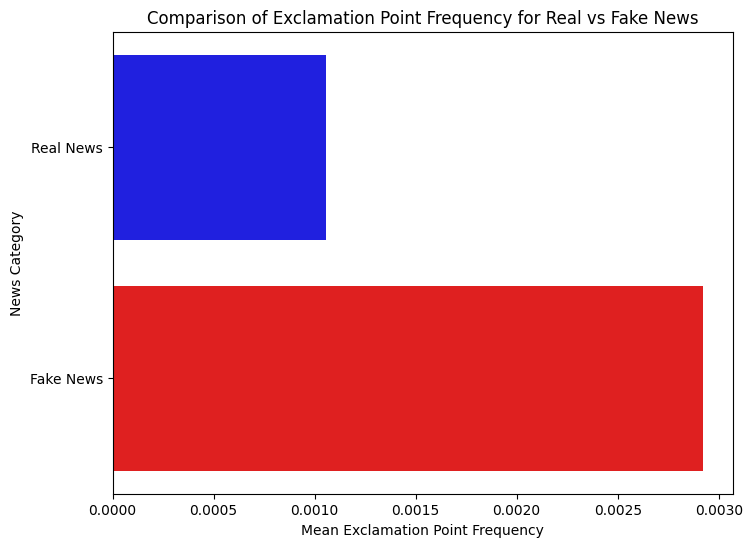

In [266]:
plotExclamationFreqs(train_data_df)


/var/folders/j1/kcm7s9bd1xj_77kfdwvq2_xc0000gn/T/ipykernel_986/2134805678.py:181: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


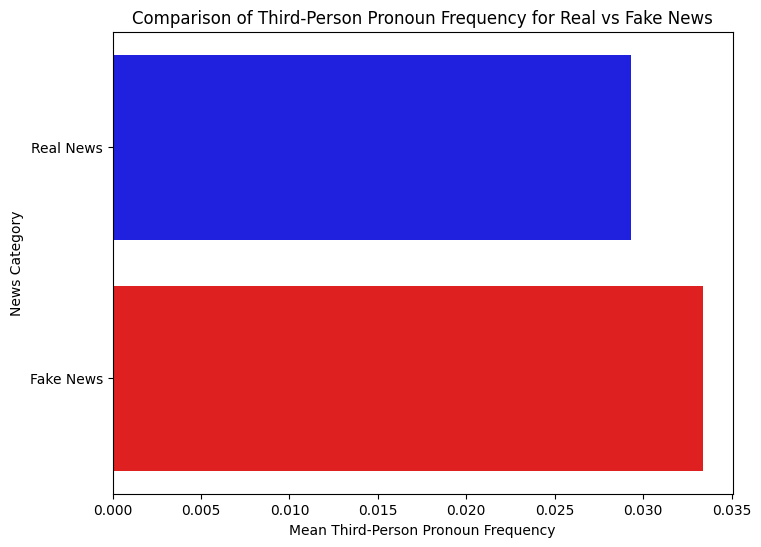

In [267]:
plotThirdPersonPronounFreqs(train_data_df)


rocessing texts for emotion analysis...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59414/59414 [03:11<00:00, 310.62it/s]

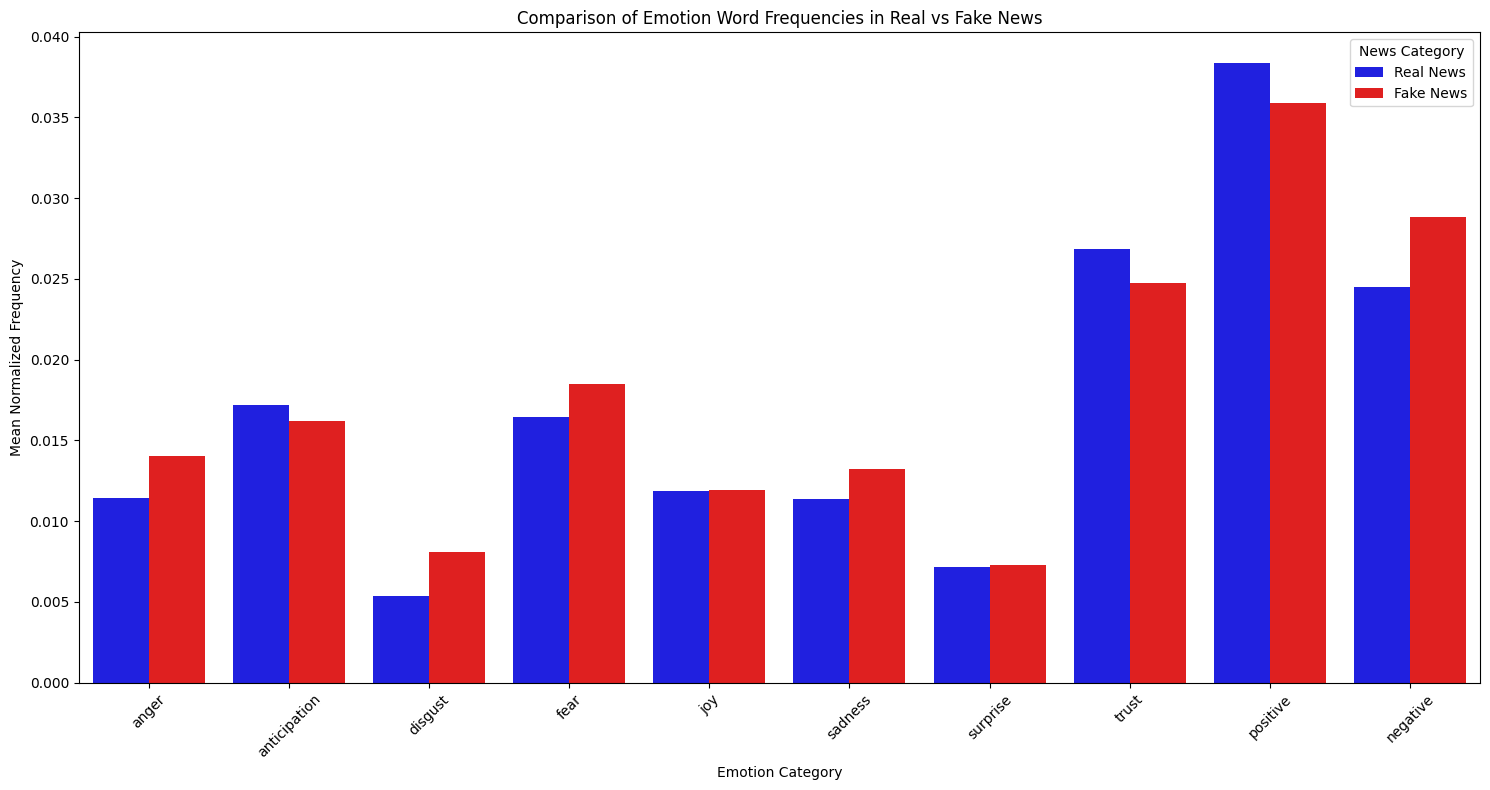

In [268]:
plotEmotionFreqs(train_data_df)


/var/folders/j1/kcm7s9bd1xj_77kfdwvq2_xc0000gn/T/ipykernel_986/744294667.py:362: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


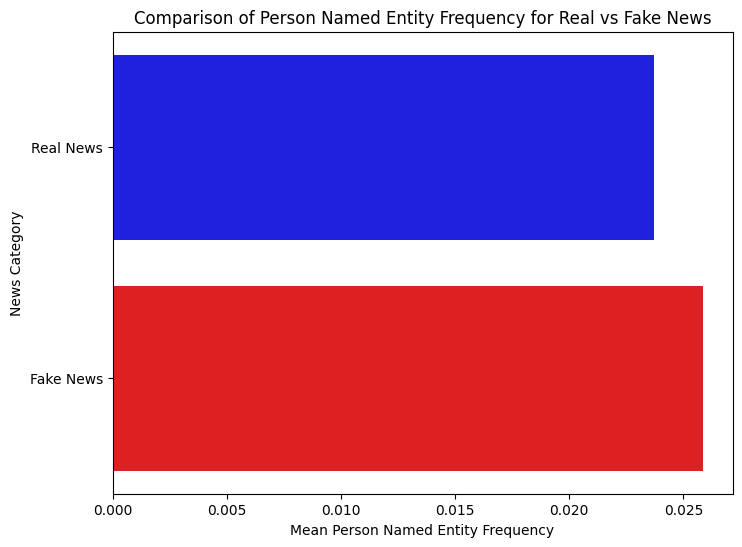

In [271]:
plotPersonNamedEntityFreqs(train_data_df)


/var/folders/j1/kcm7s9bd1xj_77kfdwvq2_xc0000gn/T/ipykernel_986/744294667.py:410: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


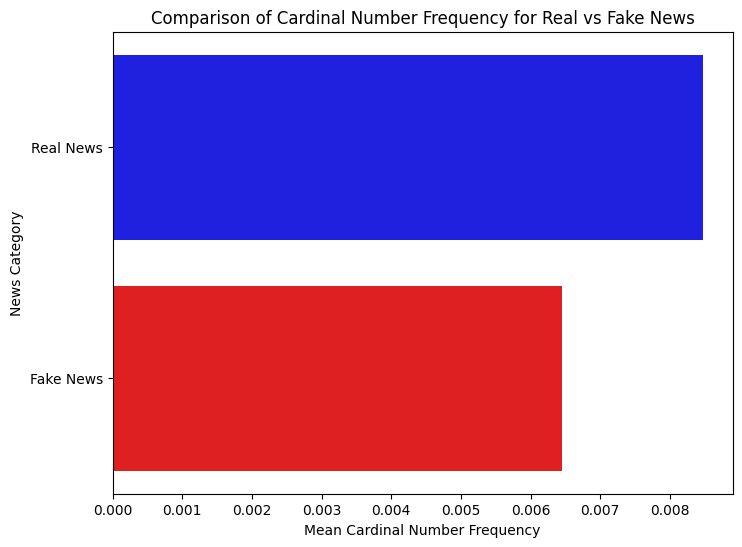

In [272]:
plotCardinalNamedEntityFreqs(train_data_df)


/var/folders/j1/kcm7s9bd1xj_77kfdwvq2_xc0000gn/T/ipykernel_90470/4244290643.py:486: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


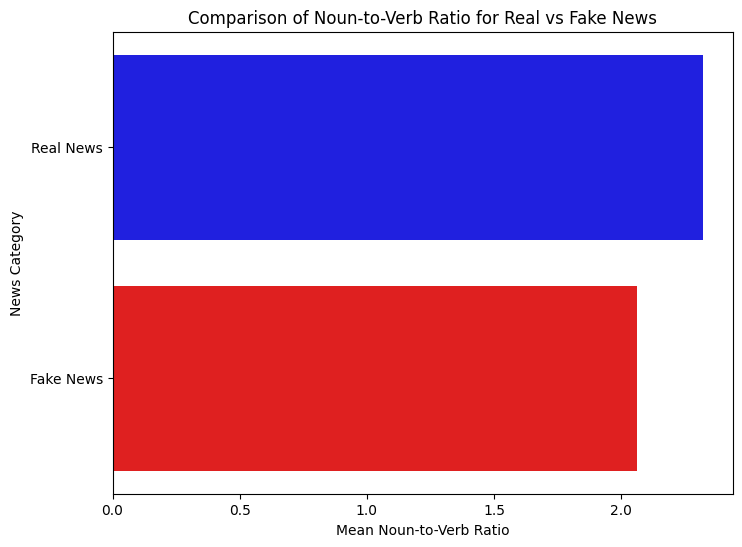

In [7]:
plotNounToVerbRatios(train_data_df)


/var/folders/j1/kcm7s9bd1xj_77kfdwvq2_xc0000gn/T/ipykernel_90470/3196981520.py:535: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


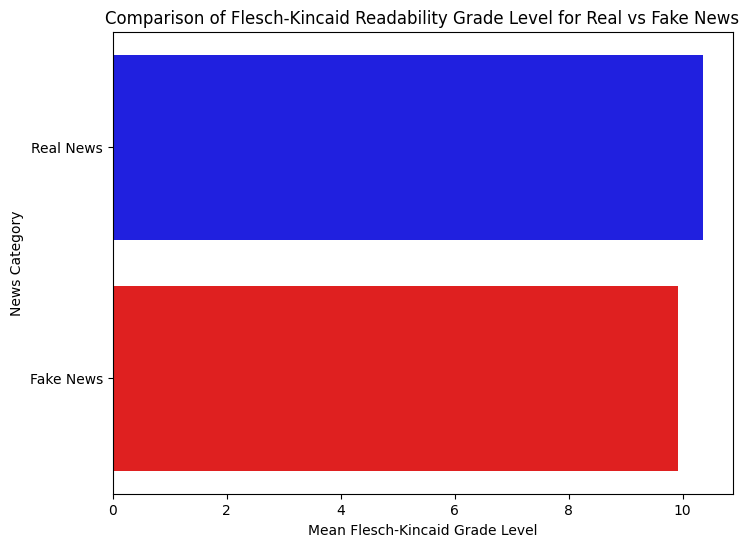

In [12]:
plotFleschKincaidReadability(train_data_df)


/var/folders/j1/kcm7s9bd1xj_77kfdwvq2_xc0000gn/T/ipykernel_90470/3196981520.py:585: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


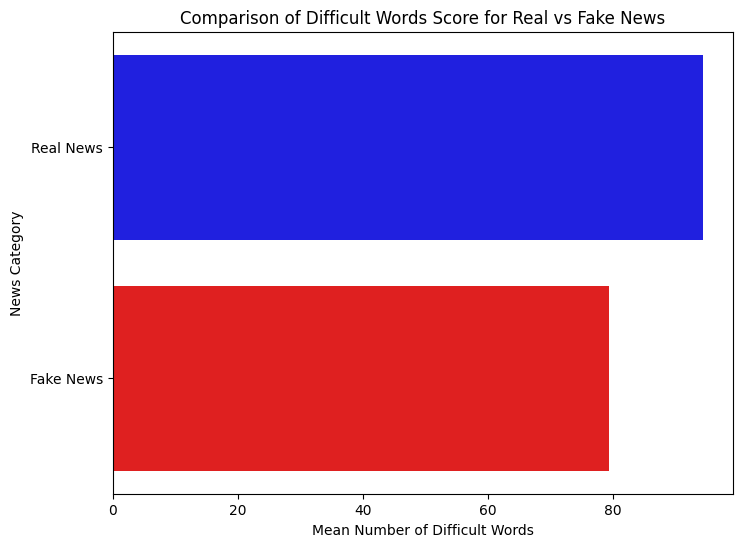

In [14]:
plotDifficultWordsScore(train_data_df)

## Creating and Training the Second Model Pipeline with TF-IDF and Extra Features

In [98]:
best_hyperparams_as_dict

{'col_transformer__tfidf__max_df': 0.7,
 'col_transformer__tfidf__max_features': 50000,
 'col_transformer__tfidf__min_df': 1,
 'pac_model__C': 2.6673182125473516,
 'pac_model__loss': 'squared_hinge'}

In [99]:
def trainPipelineForLIMEExplanations(train_df, extra_feature_columns, hyperparams):
    """
    Trains a Passive-Aggressive Classifier wrapped with CalibratedClassifierCV
    (for outputting probabilities) and integrate LIME for generating explanations.

        Input Parameters:
            train_df (pd.DataFrame): the training data containing text, extra features, and labels.
            extra_feature_columns (list): a list of column names for extra features.
            hyperparams (dict): a dictionary containing the hyperparameters to be used for training TF-IDF and PA pipeline
            
        Output:
            pipeline (Pipeline): Trained pipeline including the calibrated PAC model.
    """
    
    # Sets up the TF-IDF Vectorizer with unigram, bigram, and trigram range
    tfidf_vectorizer = TfidfVectorizer(
        ngram_range=(1, 3), # Implements 1,3 n-gram range for representing phrases and collocations
        strip_accents="unicode", # Replaces accents
        max_df=hyperparams["col_transformer__tfidf__max_df"],  # Uses the saved hyperparams
        max_features=hyperparams["col_transformer__tfidf__max_features"]
    )

    # Defines the Column Transformer to combine TF-IDF feature matrices with extracted features such as exclamation mark count
    col_transformer = ColumnTransformer(
        transformers=[
            ("tfidf", tfidf_vectorizer, "text"),
            # Extracts extra features from inputted list and scale all features to remove extreme overdominating values
            ("extra_features", StandardScaler(), extra_feature_columns) 
        ],
        remainder="drop" # Drops all the remaining DataFrame columns not required as features
    )

    # Defines a Passive-Aggressive Classifier with optimized hyperparameters from dict, use random_state for reproducibility
    pac_model = PassiveAggressiveClassifier(
        C=hyperparams["pac_model__C"],  # Tuned C-regularization param
        loss=hyperparams["pac_model__loss"],  # Tuned loss function
        random_state=5  # For reproducibility
    )

    # Wraps the Passive-Aggressive Classifier model to get probabilities using CalibratedClassifierCV
    calib_pac_model = CalibratedClassifierCV(pac_model, method="sigmoid")

    # Combines all these steps into a Pipeline
    pipeline = Pipeline(steps=[
        ("col_transformer", col_transformer), # TF-IDF plus extra features
        ("calib_pac_model", calib_pac_model) # Wrapps the Passive-Aggressive Classifier model
    ])

    # Trains the model
    X = train_df[["text"] + extra_feature_columns] # Extracts text plus other features
    y = train_df["label"] # Extracts the labels
    
    print("Training the model with calibrated Passive-Aggressive classifier...")
    pipeline.fit(X, y)
    
    print("Training complete.")

    return pipeline

In [100]:
def classifierEvaluation(y_test, y_pred, dataset_name, average_type="macro", cmap="viridis"):
  """
    Reusable function for evaluating classifier performance using different metrics.
    
    Input Parameters:
      y_test (list): list of ground truth fake news labels (0 = real, 1 = fake)
      y_pred (list): list of predicted labels
      average_type (str): determines whether to use macro or micro evaluation metrics, macro is better when classes are imbalanced to gauge performance on minority
      cmap (str): matplotlib colormap for Seaborn-generated confusion matrix
    Output:
      dictionary storing scores for 4 evaluation metrics
  """

  # Calculates the basic metrics
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average=average_type) # Uses macro due to class imbalance
  macro_f1 = f1_score(y_test, y_pred, average=average_type)

  # Prints the results
  print(f"Accuracy: {accuracy:.4f}")
  print(f"Precision (Macro): {precision:.4f}")
  print(f"Recall (Macro): {recall:.4f}")
  print(f"Macro F1-score: {macro_f1:.4f}")

  # Prints the classification report
  print("\nClassification Report:\n")
  print(classification_report(y_test, y_pred))

  # Generates a confusion matrix
  c_matrix = confusion_matrix(y_test, y_pred)

  # Visualizes the confusion matrix using Seaborn heatmap
  plt.figure(figsize=(6, 5)) # Set figure size
  sns.heatmap(c_matrix, annot=True, fmt='d', cmap=cmap,
            xticklabels=["real", "fake"], yticklabels=['real', 'fake']) # Maps 0 = real, 1 = fake
  plt.title(f"Confusion Matrix for {dataset_name}")
  plt.xlabel("Predicted Class")
  plt.ylabel("Ground Truth")
  plt.show()

  return {"accuracy": accuracy, "precision": precision, "recall": recall, "macro_f1": macro_f1}

In [102]:
class BasicFeatureExtractor:
    """
        Functions for extracting basic features such as frequency counts for parts of speech
        and punctuation marks for pre-processing a fake news dataset before classification,
        to contain basic semantic and linguistic features as well as just word features.
    """
    
    def __init__(self):
        
        # Loads in the SpaCy large English model
        self.nlp = spacy.load("en_core_web_lg")
        print("Finished loading large SpaCy model!")


    def extractExclamationPointFreqs(self, text):
        """
        Extracts normalized (by text length in number of tokens)
        frequencies of exclamation points per inputted news text.
        
            Input Parameters:
                text (str): the news text to extract exclamation point frequencies from.
    
            Output:
                excl_point_freq (float): the normalized exclamation point frequency for the text.
                Normalized by num of word tokens to handle varying text length datasets.
        """
        # Counts the number of exclamation points in the text
        exclamation_count = text.count("!")
        
        # Counts word tokens for text length
        word_tokens = word_tokenize(text)
        text_length = len(word_tokens)
        # Normalizes the exclamation point frequency
        return exclamation_count / text_length if text_length > 0 else 0 # Handle division-by-zero errs


    def extractThirdPersonPronounFreqs(self, text):
        """
        Extracts the normalized frequency counts of third-person pronouns in the inputted news text.
        
            Input Parameters:
                text (str): the news text to extract pronoun features from.
            
            Output:
                float: Normalized third-person pronoun frequency.
        """
        # Defines the list of third-person pronouns
        third_person_pronouns = [
            "he", "she", "it", "they", "he's", "she's", "it's", "they're", 
            "they've", "they'd", "they'll", "his", "her", "its", "their", 
            "hers", "theirs", "him", "them", "one", "one's", "he'd", "she'd"
        ]

        # Tokenizes the text into words
        word_tokens = word_tokenize(text)
        text_length = len(word_tokens)

        # Counts frequency of third-person pronouns in the news text, lower to match the list above
        third_person_count = sum(1 for token in word_tokens if token.lower() in third_person_pronouns)

        # Normalizes the frequency by text length in word tokens
        return third_person_count / text_length if text_length > 0 else 0



    def extractNounToVerbRatios(self, text):
        """
        Calculates the ratio of all types of nouns to all types of verbs in the text
        using the Penn Treebank POS Tagset and the SpaCy library with the
        "en_core_web_lg" model.
            
            Input Parameters:
                text (str): the news text to extract noun-verb ratio features from.
            
            Output:
                float: Noun-to-verb ratio, or 0.0 if no verbs are present.
        """
        # Converts the text to an NLP doc object using the SpaCy library.
        doc = self.nlp(text)
        
        # Defines the Penn Treebank POS tag categories for nouns and verbs
        # Reference here: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
        noun_tags = ["NN", "NNS", "NNP", "NNPS"]
        verb_tags = ["VB", "VBD", "VBG", "VBN", "VBP", "VBZ"]
        
        # Counts nouns and verbs based on the Penn Treebank tags
        noun_count = sum(1 for token in doc if token.tag_ in noun_tags)
        verb_count = sum(1 for token in doc if token.tag_ in verb_tags)
        
        # Computes and return the noun-to-verb ratio (should be higher for fake news, more nouns)
        return noun_count / verb_count if verb_count > 0 else 0.0


    def extractCARDINALNamedEntityFreqs(self, text):
        """
        Extracts the normalized frequency of CARDINAL named entities in the text
        using the SpaCy library.
        
            Input Parameters:
                text (str): The text to extract the CARDINAL named entity frequencies from.
            
            Output:
                float: Normalized frequency (by number of tokens in the text) of CARDINAL named entities.
        """
        # Processes the text with SpaCy to get NLP doc object
        doc = self.nlp(text)
         # Counts how many named entities have the label "CARDINAL"
        cardinal_entity_count = sum(1 for entity in doc.ents if entity.label_ == "CARDINAL")

        # Tokenizes the text and calculate its length
        word_tokens = [token for token in doc]
        text_length = len(word_tokens)

        # Returns the normalized frequency of CARDIAL named entities
        return cardinal_entity_count / text_length if text_length > 0 else 0.0


    def extractPERSONNamedEntityFreqs(self, text):
        """
        Extracts the normalized frequency of PERSON named entities in the text
        using the SpaCy library.
        
            Input Parameters:
                text (str): The text to extract the PERSON named entity frequencies from.
            
            Output:
                float: Normalized frequency (by number of tokens in the text) of PERSON named entities.
        """
        # Processes the text with SpaCy to get NLP doc object
        doc = self.nlp(text)
        
        # Counts how many named entities have the label "PERSON"
        person_entity_count = sum(1 for entity in doc.ents if entity.label_ == "PERSON")
        
        # Tokenizes the text and calculate its length
        word_tokens = [token for token in doc]
        text_length = len(word_tokens)
        
        # Returns the normalized frequency of PERSON named entities
        return person_entity_count / text_length if text_length > 0 else 0.0


    def extractPositiveNRCLexiconEmotionScore(self, text):
        """
        Extracts the POSITIVE emotion score using the NRC Lexicon from the inputted news text.
        
            Input Parameters:
                text (str): the news text to extract POSITIVE emotion score from.
            
            Output:
                float: POSITIVE emotion score.
        """
        # Creates an NRC Emotion Lexicon object
        emotion_obj = NRCLex(text)
        
        # Returns the POSITIVE emotion score (use "get" to default to 0.0 if not found)
        return emotion_obj.affect_frequencies.get("positive", 0.0)


    def extractTrustNRCLexiconEmotionScore(self, text):
        """
        Extracts the TRUST emotion score using the NRC Lexicon from the inputted news text.
        
            Input Parameters:
                text (str): the news text to extract TRUST emotion score from.
            
            Output:
                float: TRUST emotion score.
        """
        
        # Creates an NRC Emotion Lexicon object
        emotion_obj = NRCLex(text)
        
        # Returns the TRUST emotion score (use "get" to default to 0.0 if not found)
        return emotion_obj.affect_frequencies.get("trust", 0.0)
        

    def extractFleschKincaidGradeLevel(self, text):
        """
        Extracts the Flesch-Kincaid Grade Level score for the input text.
        
            Input Parameters:
                text (str): the news text to calculate the Flesch-Kincaid Grade Level score.
            
            Output:
                float: the Flesch-Kincaid Grade Level score for the text.
        """
        return textstat.flesch_kincaid_grade(text)

        
    def extractDifficultWordsScore(self, text):
        """
        Extracts the number of difficult words in the input text using the textstat library.
        
            Input Parameters:
                text (str): the news text to calculate the difficult words score.
            
            Output:
                float: the number of difficult words score for the text.
        """
        return textstat.difficult_words(text)

    def extractCapitalLetterFreqs(self, text):
        """
        Extracts the normalized frequency of capital letters in the input text.
        Normalized by the total number of tokens to account for varying text lengths.
        
            Input Parameters:
                text (str): The news text to extract capital letter frequencies from.
            
            Output:
                float: Normalized frequency of capital letters in the text.
        """
        # Counts the number of capital letters in the text
        capital_count = sum(1 for char in text if char.isupper())
        
        # Tokenizes the text into words to calculate its length
        word_tokens = word_tokenize(text)
        text_length = len(word_tokens)
        
        # Normalizes the frequency of capital letters
        return capital_count / text_length if text_length > 0 else 0.0
    
    def extractBasicFeatures(self, df, dataset_name, root_save_path="../FPData/BasicFeatureExtractionDFs",):
        """
        Adds new columns to an inputted DataFrame that stores the frequency of 
        or score for various features derived from the "text" column, hopefully for 
        improved classification using a Passive Aggressive Classifier model.

            Input Parameters:
                df (pd.DataFrame): DataFrame with a "text" column containing news texts.
    
            Output:
                pd.DataFrame: a new DataFrame with the additional feature columns
        """
        # Creates a copy of the original DataFrame
        basic_feature_df = df.copy()

        # Extracts the dataset name without the ".csv" at the end
        dataset_name_without_csv_extension = dataset_name.split('.')[0]
        print(f"Extracting features for {dataset_name_without_csv_extension}...")
        
        # Applies the exclamation point frequency helper function...
        print("Extracting normalized exclamation point frequencies...")
        basic_feature_df["exclamation_point_frequency"] = basic_feature_df["text"].progress_apply(self.extractExclamationPointFreqs)
        
        # Applies the third-person pronoun frequency helper function...
        print("Extracting third person pronoun frequencies...")
        basic_feature_df["third_person_pronoun_frequency"] = basic_feature_df["text"].progress_apply(self.extractThirdPersonPronounFreqs)

        # Applies the noun-to-verb ratio helper functionn
        print("Extracting noun-to-verb ratio frequencies...")
        basic_feature_df["noun_to_verb_ratio"] = basic_feature_df["text"].progress_apply(self.extractNounToVerbRatios)

        # Applies the CARDINAL named entity frequency helper function to create a new column
        print("Extracting CARDINAL named entity frequencies...")
        basic_feature_df["cardinal_named_entity_frequency"] = basic_feature_df["text"].progress_apply(self.extractCARDINALNamedEntityFreqs)

        # Applies the PERSON named entity frequency helper function to create a new column
        print("Extracting PERSON named entity frequencies...")
        basic_feature_df["person_named_entity_frequency"] = basic_feature_df["text"].progress_apply(self.extractPERSONNamedEntityFreqs)

        # Applies the NRC Lexicon to get the POSITIVE emotion scores for each text
        print("Extracting NRC Lexicon POSITIVE emotion scores...")
        basic_feature_df["nrc_positive_emotion_score"] = basic_feature_df["text"].progress_apply(self.extractPositiveNRCLexiconEmotionScore)

        # Applies the NRC Lexicon to get the TRUST emotion scores for each text
        print("Extracting NRC Lexicon TRUST emotion scores...")
        basic_feature_df["nrc_trust_emotion_score"] = basic_feature_df["text"].progress_apply(self.extractTrustNRCLexiconEmotionScore)

        # Applies textstat package to get the Flesch-Kincaid U.S. Grade Level readability score
        print("Extracting Flesch-Kincaid U.S. Grade readability scores...")
        basic_feature_df["flesch_kincaid_readability_score"] = basic_feature_df["text"].progress_apply(self.extractFleschKincaidGradeLevel)

        # Applies textstat package to get the difficult_words readability score
        print("Extracting difficult words readability scores...")
        basic_feature_df["difficult_words_readability_score"] = basic_feature_df["text"].progress_apply(self.extractDifficultWordsScore)

        # Applies counts of capital letters for each text normalized by number of tokens
        print("Extracting normalized capital letter frequency scores..")
        basic_feature_df["capital_letter_frequency"] = basic_feature_df["text"].progress_apply(self.extractCapitalLetterFreqs)

        print("\n\n")

        # Saves the extra features DataFrame to disk as .csv file
        basic_feature_df.to_csv(os.path.join(root_save_path, dataset_name), index=False)
        
        return basic_feature_df

    def extractExtraFeaturesColumns(self, df):
        """
            Extracts the columns with the extra features only

            Input Parameters:
                df (pd.DataFrame): DataFrame with a "text" column and extra features columns

            Output:
                df (pd.DataFrame): DataFrame with the extracted features only
        """
        return df[[
        "exclamation_point_frequency", "third_person_pronoun_frequency", "noun_to_verb_ratio",
        "cardinal_named_entity_frequency", "person_named_entity_frequency", 
        "nrc_positive_emotion_score", "nrc_trust_emotion_score", 
        "flesch_kincaid_readability_score", "difficult_words_readability_score", 
        "capital_letter_frequency"
    ]]

    def extractFeaturesForSingleText(self, text):
        """
        Function that extracts all features for a single text instance.
    
        Input Parameters:
            text (str): The text to extract features from.
    
        Output:
            dict: A dictionary of extracted feature values.
        """
        feature_dict = {
            "exclamation_point_frequency": self.extractExclamationPointFreqs(text),
            "third_person_pronoun_frequency": self.extractThirdPersonPronounFreqs(text),
            "noun_to_verb_ratio": self.extractNounToVerbRatios(text),
            "cardinal_named_entity_frequency": self.extractCARDINALNamedEntityFreqs(text),
            "person_named_entity_frequency": self.extractPERSONNamedEntityFreqs(text),
            "nrc_positive_emotion_score": self.extractPositiveNRCLexiconEmotionScore(text),
            "nrc_trust_emotion_score": self.extractTrustNRCLexiconEmotionScore(text),
            "flesch_kincaid_readability_score": self.extractFleschKincaidGradeLevel(text),
            "difficult_words_readability_score": self.extractDifficultWordsScore(text),
            "capital_letter_frequency": self.extractCapitalLetterFreqs(text),
        }
        # Converts to DataFrame (single row)
        feature_df = pd.DataFrame([feature_dict])
        return feature_df

In [103]:
# Creates an instance of the feature extractor classs
feat_extractor = BasicFeatureExtractor()

Finished loading large SpaCy model!


## Integrating LIME Functionality with Extra Features

In [200]:
def explainPredictionWithLIME(trained_pipeline, text, feature_extractor, num_features=50, num_perturbed_samples=500):
    """
    Extracts the extra (semantic and linguistic) features for a **single** text, applies TF-IDF to the text,
    and inputs the processed featureset for the text into the pre-trained Passive-Aggressive Pipeline.
    Generates the probability for the news text being either real news or fake news, and also
    generates a LIME-based explanation for the prediction

        Input Parameters:
            trained_pipeline (scikit-learn.Pipeline): a pre-trained Pipeline consisting of tuned TF-IDF, PA Classifier, and Calibrated
                Classifier for returning probabilities.
            text (str): the text to get the prediction for
            feature_extractor (instance of BasicFeatureExtractor class): the object containing a method for extracting the extra
                features for the news text
            num_features (int): number of "important features" contributing to the final prediction that the LIME explainer should
                                output.
            num_perturbed_samples (int): number of times LIME should create perturbations of the entered original text to see how
                                         changing certain features leads to differences in predicted probabilities
        Output:
            dict: stores different outputs based on the LIME explainer, such as the explanation object, original array of real-fake
                  prediction probabilities, a list of tuples for the importance scores for each word and extra feature etc.
    """
    
    print("Initializing the LIME explainer instance...")
    
    # Defines the Lime Text Explainer
    text_explainer = LimeTextExplainer(class_names=["real", "fake"])
    
    print("Extracting features for the input text...")
    # Extracts the linguistic features for the single text inputted as "text" in the args
    single_text_df = feature_extractor.extractFeaturesForSingleText(text)
    single_text_df["text"] = text
    
    # Stores the original extra features for generating later LIME explanations of how much they contributed to the final prediction
    extra_features = single_text_df.drop("text", axis=1) # Drops the text column to get only extra features columns
    extra_feature_names = extra_features.columns  # Extracts the names of the extracted features

    
    def predict_proba(texts):
        """
        This helper function processes (extracts features) and then predicts the probabilities (2-element array) for
        each of the perturbed text samples.
        Then it uses the pre-trained Pipeline to return arrays of probabilities [prob_real, prob_fake] for each perturbed text.
        """
        
        print(f"Predicting probabilities for {len(texts)} perturbed LIME texts...")      

        # Stores the DataFrames for extracted features + text for all the perturbed texts
        df_list = []  
        
        # Iterates over perturbed LIME-texs
        for text in texts:
            
            # Extracts the extra semantic and linguistic features for each perturbation of original text
            df = feature_extractor.extractFeaturesForSingleText(text)
            
            # Adds the text column to extracted features single-row DataFrame
            df["text"] = text
            
            # Adds the single row DataFrame storing extracted features and text to list for concatenating all perturbed sample information
            df_list.append(df)
            
        # Combines single-row DataFrames for all perturbed LIME texts into single DataFrame, vertically stack with concatenate function
        combined_df = pd.concat(df_list, axis=0, ignore_index=True)
        
        # Extracts the probabilities of all the perturbed feature-text LIME samples using the pipeline
        probs_for_texts = trained_pipeline.predict_proba(combined_df)
        
        return probs_for_texts
        

    # Uses the model to get the prediction for real or fake news for the text (as there is a single text only, access first elem with [0])
    prediction = trained_pipeline.predict(single_text_df)[0]
    
    text_representation_of_prediction = "Fake News" if prediction == 1 else "Real News"
    
    print(f"Main prediction: {prediction} = {text_representation_of_prediction}.\nGenerating LIME explanation for the text...")

    # Generates the LIME explanation
    explanation = text_explainer.explain_instance(
        text, # Single original news text
        predict_proba, # Function outputting probabilities for perturbed samples
        num_features=num_features, # The number of top word-features to output in explanation (default = 50)
        top_labels=1, # Explains only the top-predicted label
        num_samples=num_perturbed_samples, # Number of perturbations; a higher value increases accuracy but takes more time. Default = 500
        labels=[prediction] # Gets the predicted label for this news text (to explain it)
    )
    
    # Gets the text feature explanations
    print("Generating LIME explanations based on 500 perturbed samples...")
    text_features = explanation.as_list(label=prediction)
    
    # Converts the outputted text_features to a list of tuples storing (word, importance_score)
    text_feature_list = [(feature[0], feature[1]) for feature in text_features 
                             if feature[0].lower() not in stop_words] # Filters out text features that are stopwords like "the", "an", etc.
    
    # Sorts the text_feature_list by absolute value of importance scores in descending order
    text_feature_list_sorted = sorted(text_feature_list, key=lambda x: abs(x[1]), reverse=True)
    print(f"text_feature_list_sorted: {text_feature_list_sorted }")
    
    # Generates explanations for extra features based on perturbing them
    print("\nCalculating extra feature importance scores...")

    # Stores the extra features' importance in this list of tuples (feature_name, feature_importance)
    extra_feature_importances= []

    # Extracts the probability array [real_news_probability, fake_news_probability] for the single, unperturbed news text
    original_text_probability_array = trained_pipeline.predict_proba(single_text_df)[0]

    # Iterates through the extra features
    for feature in extra_feature_names:
        
        # Creates perturbed version of the DataFrame storing the extra features
        perturbed_df = single_text_df.copy()
        
        # Extracts the original value of the feature 
        original_value = perturbed_df[feature].iloc[0] # A single row frame, so gets the first row out
        
        # Calculates this particular feature's importance for the prediction by setting its value to 0, and predicting 
        # the probability array using the Pipeline for real vs fake news WITHOUT this feature (i.e. set to 0)
        perturbed_df[feature] = 0
        perturbed_probability_array = trained_pipeline.predict_proba(perturbed_df)[0]
        
        # Calculates the feature's importance as difference in probabilities using the main prediction 
        importance = original_text_probability_array[prediction] - perturbed_probability_array[prediction]

        # Appends the importance of the feature to the extra_feature_importances list-of-tuples
        extra_feature_importances.append((feature, importance))
    
    # Sorts the extra features by absolute value of the feature importance scores (at index 1 in the name-score tuples) in descending order
    extra_feature_importances.sort(key=lambda x: abs(x[1]), reverse=True)
    print("Extra feature importance scores (sorted in descending order):", extra_feature_importances)

    # Visualizes the text with highlighted words based on their importance scores
    highlighted_text = highlightText(text, text_feature_list_sorted, prediction)
    
    # Combines both explanations in the returned dictionary
    return {
        "explanation_object": explanation,
        "text_features_list": text_feature_list,
        "extra_features_list": extra_feature_importances,
        "highlighted_text": highlighted_text,
        "probabilities": original_text_probability_array,
        "main_prediction": prediction
    }


def highlightText(text, text_feature_list, prediction):
    """
    Highlights the words in the input text based on their importance scores and their impact on the prediction.
    Red for words pushing towards fake news (label=1) and blue for words pushing towards real news (label=0).

        Input Parameters:
            text (str): the text to highlight
            text_feature_list (list of tuples): list of word-feature, importance-score tuples outputted by LIME important feature detector
            prediction (int): 0 if real news, 1 if fake news
        Output:
            IPython.display HTML object: highlighted text to display
    """
    
   # Stores the dictionaries containing positions, colors and opacities for highlighting parts of the text
    highlight_positions = []
    
    # Stores store the dictionaries containing positions, colors and opacities for highlighting parts of the text
    highlight_positions = []
    
    # Calculates the maximum absolute importance score
    max_importance = max(abs(importance) for feature, importance in text_feature_list)

    # Finds all positions to highlight first using the important word tuples
    for feature, importance in text_feature_list:
        
        pos = 0  # Starts the position as beginning of the string for searching
        
        while True:
            # Finds the next occurrence of the word from the starting position
            pos = text.lower().find(feature.lower(), pos)

            # Resets the loop to the next word feature if this word is no longer found from the starting positions
            if pos == -1:
                break
                
            # Checks word boundaries to not match on parts of words
            boundary_positions = detectWordBoundaries(text, pos, feature)

            # If word is only a partial match, moves the position marker by 1 in the string, and goes to next part of the str
            if boundary_positions is None:
                pos += 1 
                continue

            # If boundary positions are returned, add them to a new word-highlight dictionary
            word_start_pos, word_end_pos = boundary_positions
            
            # Adds the position information for future highlighting
            highlight_positions.append({
                "start": word_start_pos,
                "end": word_end_pos,
                "color": "red" if importance > 0 else "blue",
                "opacity": abs(importance) / max_importance if max_importance != 0 else 0,
                "text": text[word_start_pos:word_end_pos]
            })

            # Moves past the end of this current word to the next position
            pos = word_end_pos  

    # Sorts the positions by their start position
    highlight_positions.sort(key=lambda word_dict: word_dict["start"])
    
    # Merges the adjacent highlights of the same color, as users wanted to see n-grams and word clusters not just single keywords
    merged_positions = []

    # If there are words to highlight, then continue
    if highlight_positions:

        # Set current marker to the first (sorted) word to highlight dict
        current = highlight_positions[0]

        # Iterate over all the next highlight dicts to find places to merge
        for next_pos in highlight_positions[1:]:
            
            # If the next position starts right after current ends (or overlaps) and has same color
            if (next_pos["start"] <= current["end"] + 1 and 
                next_pos["color"] == current["color"]):
                
                # Merges the two words by extending current position
                current["end"] = max(current["end"], next_pos["end"])
                current["opacity"] = max(current["opacity"], next_pos["opacity"])
                current["text"] = text[current["start"]:current["end"]]
            else:
                # If the positions do not overlap, adds to the current to results and move to next
                if next_pos["start"] > current["end"]:
                    merged_positions.append(current)
                    current = next_pos
                else:  # If the words overlap but are of different colors - keeps only the one with higher opacity
                    if next_pos["opacity"] > current["opacity"]:
                        current = next_pos
        
        merged_positions.append(current)  # Adds the last position

    # Builds the final highlighted text using HTML and inline CSS colors
    result = []
    last_end = 0

    # Iterates over merged highlights dictionaries
    for pos in merged_positions:
        # Adds the non-highlighted text from the start of the text
        if pos["start"] > last_end:
            result.append(text[last_end:pos["start"]])
        
        # Adds the highlighted text
        color = "rgba(255, 0, 0," if pos["color"] == "red" else "rgba(100,149,237,"  # red or RGB code for "cornflowerblue" color
        background_style = f"{color}{pos['opacity']})"

        # Appends the highlighted text to the result
        result.append(
            f"<span style='background-color:{background_style}; font-weight: bold'>"
            f"{pos['text']}</span>"
        )

        # Updates the marker to the end of the hgihlight
        last_end = pos["end"]
    
    # Adds any remaining text at the end to the string
    if last_end < len(text):
        result.append(text[last_end:])

    # Joins the HTML marked up string
    return HTML(f"<p>{''.join(result)}</p>")


def detectWordBoundaries(text, word_start_pos, word):
    """
    Ensures that matching whole words only when highlighting text
    Returns the start and end position if it's a valid word boundary, None otherwise
    
        Input Parameters:
            text (str): the whole text the sub-string to highlight is part of
            word_start_pos (int): starting position of word (feature)
            word (str): the word feature to highlight
    
        Output:
            IF word is indeed a word surrounded by a boundary:
                returns tuple of word_start_pos (int), word_end_pos (int):
            ELSE (if invalid word boundary):
                returns None
    """
    # Defines a set of punctuation characters for detecting word boundaries, such as space, exclamation mark, hyphen
    boundary_chars = set(' .,!?;:()[]{}"\n\t-')
    
    # Checks if the word is at the proper word boundaries: either position is the start_position (0) or the 
    # previous character before the word is inside of the boundary_chars set for detecting w boundaries
    start_boundary_check = word_start_pos == 0 or text[word_start_pos - 1] in boundary_chars
    
    # Sets the end position to the character after the word to check if it is a boundary-marking characters
    word_end_pos = word_start_pos + len(word)
    end_boundary_check = word_end_pos == len(text) or text[word_end_pos] in boundary_chars # Checks if end is true end or a boundary char

    # If word boundary is around this word, then return the starting and end position of the word in the text
    if start_boundary_check and end_boundary_check:
        return word_start_pos, word_end_pos

    # If not a word boundary, return None
    return None

In [104]:
# Trains the TF-IDF + Passive Aggressive Classifier + CalibratedCV Classifier (for outputting probabilities) on the training data
trained_pipeline = trainPipelineForLIMEExplanations(train_data_df, extra_feature_columns, best_hyperparams_as_dict)

Training the model with calibrated Passive-Aggressive classifier...
Training complete.


Accuracy: 0.9093
Precision (Macro): 0.9053
Recall (Macro): 0.9037
Macro F1-score: 0.9045

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      8656
           1       0.89      0.88      0.88      5531

    accuracy                           0.91     14187
   macro avg       0.91      0.90      0.90     14187
weighted avg       0.91      0.91      0.91     14187



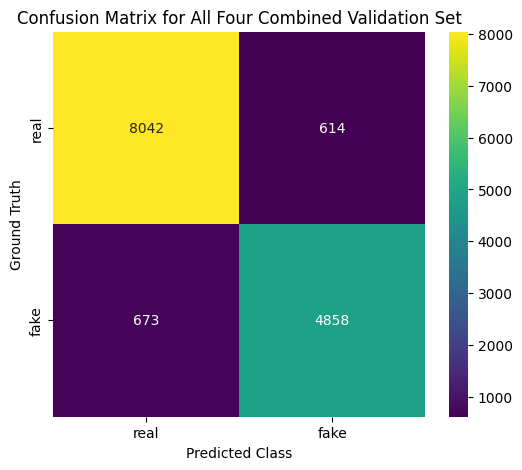

In [106]:
# Calculates the validation set predictions from the pipeline trained above
X_val = val_data_df[["text"] + extra_feature_columns]
y_val = val_data_df["label"]
y_val_pred = trained_pipeline.predict(X_val)

# Evaluates performance on the All-four combined validation set
eval_dict = classifierEvaluation(
    y_val,  
    y_val_pred,
    dataset_name="All Four Combined Validation Set",
    average_type="macro", 
    cmap="viridis"
)

In [108]:
# Saves the calibrated CV model
joblib.dump(trained_pipeline, "iteration2_lime_model.pkl")

['iteration2_lime_model.pkl']

In [109]:
# Checks this has worked
trained_pipeline = joblib.load("iteration2_lime_model.pkl")

In [135]:
# Uses a random text to test LIME (from PolitiFact validation data set, accessed at idx 1)
random_text = """
Hillary Clinton had a third and most-likely fatal heart attack this afternoon after spending the morning being told she’d be getting better. It almost seems fitting that the last thing she hears is a lie about her own well-being.

The Butcher of Benghazi will meet her maker, says Doctor Eugene Icsa of Westchester Memorial Hospital in upstate New York, as the damage to her heart is irreparable at this point:

“Secretary Clinton fought hard but today her fight is over. We predict she’ll be at rest within hours.”

The Clinton family has asked for privacy and wouldn’t answer questions about whether or not they had to decide to “pull the plug” or if they’re simply being told nothing can be done. Chelsea Clinton was seen entering the hospital in tears shortly after noon, according to a new report from LLOD correspondent Skip Tetheluda:

“Chelsea came alone and was obviously distraught. She made no comment to the press but did stop to tell one photographer to have some respect while she ‘visits a great woman for the last time.’ She hasn’t come out and is presumably sitting and waiting to say goodbye. Bill Clinton is sitting on the front porch of the Chappaqua mansion drinking what looks like either tomato juice or a Bloody Mary.”

We’ll update you as soon as we confirm that Clinton has gone on to answer for her crimes with an eternity in Hell.

"""

In [205]:
# Uses a LIME function on single text to get explanations dictionary with probabilities, explanations etc.
explanations = explainPredictionWithLIME(
    trained_pipeline, # Pre-trained pipeline
    random_text, # Text to get the LIME explanations for
    feat_extractor, # BasicFeatureExtractor instance
    num_perturbed_samples=500 # Generates LIME explanations by perturbing the the 500 times
)

Initializing the LIME explainer instance...
Extracting features for the input text...
Main prediction: 1 = Fake News.
Generating LIME explanation for the text...
Predicting probabilities for 500 perturbed LIME texts...
Generating LIME explanations based on 500 perturbed samples...
text_feature_list_sorted: [('tears', -0.07095940549582089), ('thing', 0.0527681262697435), ('seen', 0.05251006650622633), ('decide', 0.04774940641503146), ('woman', 0.04649586654413224), ('simply', 0.04622168727326471), ('fought', -0.04262305490888281), ('hospital', 0.040891137292174404), ('rest', -0.03901084480054374), ('morning', 0.037718387090967545), ('Doctor', 0.03744250788229368), ('Hillary', 0.03739313450594634), ('privacy', -0.037102034553627705), ('presumably', -0.03458283369885611), ('drinking', 0.03444929164674136), ('mansion', 0.03331792607833834), ('Bloody', -0.03046141414129566), ('meet', 0.029885146309347972), ('shortly', -0.029366487611357683), ('heart', -0.029190951822712936), ('Chelsea', 0.0

In [206]:
# Generates the highlighted_text: a IPython HTML object
highlighted_text = explanations["highlighted_text"]

# Displays the highlighted text using IPython display built-in function
display(highlighted_text)